## Set global variables

In [1]:
course_metrics = {'course_name' : [],
                  'val_binary_accuracy' : [],
                  'test_accuracy' : [],
                  'test_f1_score' : [] }

In [2]:
import os

In [3]:
CONSOLIDATED_DATA_DIR = 'processed/'
COURSE_LIST = [d[0][10:] for d in os.walk(CONSOLIDATED_DATA_DIR)][1:]

In [4]:
COURSE_LIST

['HarvardXCB22x2013_Spring',
 'HarvardXCS50x2012',
 'HarvardXER22x2013_Spring',
 'HarvardXPH207x2012_Fall',
 'HarvardXPH278x2013_Spring',
 'MITx14.73x2013_Spring',
 'MITx2.01x2013_Spring',
 'MITx3.091x2012_Fall',
 'MITx3.091x2013_Spring',
 'MITx6.002x2012_Fall',
 'MITx6.002x2013_Spring',
 'MITx6.00x2012_Fall',
 'MITx6.00x2013_Spring',
 'MITx7.00x2013_Spring',
 'MITx8.02x2013_Spring',
 'MITx8.MReV2013_Summer']

In [5]:
DATA_DIR = 'processed-final/'

## Design the feed-forward neural net

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf

C:\Users\kimmcodxb\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
np.random.seed(20130810)
tf.set_random_seed(20130810)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
%matplotlib inline
sns.set_style('ticks', {'grid_color' : '0.9'})
sns.set_context('talk', font_scale=1.2)
sns.set_palette('gray')

In [10]:
from keras.models import Sequential, load_model

from keras.layers import Dense, Activation, Dropout

from keras.losses import binary_crossentropy

from keras.optimizers import RMSprop, Adam

from keras.metrics import binary_accuracy

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras import backend as K

Using TensorFlow backend.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [12]:
def build(network_type=Sequential, 
          nb_initial_layer=64,
          dense_layer_lst=[64],
          nb_final_layer=1,
          dpt_rate=0.2,
          learning_rate=1e-4):
    
    model = network_type()
    
    model.add(Dense(nb_initial_layer, input_shape=(features_train.shape[1], )))
    model.add(Activation('relu'))
    
    model.add(Dropout(dpt_rate))
    
    for nb_units in dense_layer_lst:
        model.add(Dense(nb_units))
        model.add(Activation('relu'))
        model.add(Dropout(dpt_rate))
        
    model.add(Dense(nb_final_layer))
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss=binary_crossentropy,
                  metrics=[binary_accuracy])
    
    return model

In [13]:
def plot_loss(fit_history, course_name):
    epochs = range(1, len(fit_history['binary_accuracy'])+1)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(epochs, fit_history['loss'], '--', label='Training loss')
    plt.plot(epochs, fit_history['val_loss'], '-', label='Validation loss')
    
    plt.title('Training and Validation loss for ' + course_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [14]:
def plot_accuracy(fit_history, course_name):
    epochs = range(1, len(fit_history['binary_accuracy'])+1)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(epochs, fit_history['binary_accuracy'], '--', label='Training Accuracy')
    plt.plot(epochs, fit_history['val_binary_accuracy'], '-', label='Validation Accuracy')
    
    plt.title('Training and Validation accuracy for ' + course_name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

## Tune the network for each course

### 1. CB22x - Ancient Greek Hero

In [15]:
course_idx = 0
print(COURSE_LIST[course_idx])

HarvardXCB22x2013_Spring


In [16]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

processed-final/HarvardXCB22x2013_Spring


In [17]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [18]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [19]:
features_train.shape

(24001, 18)

In [20]:
labels_train.shape

(24001,)

In [21]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [22]:
features_train.shape, features_validation.shape

((19200, 18), (4801, 18))

In [23]:
labels_train.shape, labels_validation.shape

((19200,), (4801,))

In [24]:
K.clear_session()

In [25]:
model = build(nb_initial_layer=32, dense_layer_lst=[32, 32, 32], dpt_rate=0.2, learning_rate=1e-3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                608       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [27]:
# We wish to save multiple best models.
# Main purpose is to make it easier to choose the final model as we hand tune. We delete excess saved models at the end to 
# get to the best model
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
# In case you wish to save only the best model
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [28]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

Train on 19200 samples, validate on 4801 samples
Epoch 1/50
19200/19200 [==============================] - 1s 43us/step - loss: 0.8422 - binary_accuracy: 0.5495 - val_loss: 0.6707 - val_binary_accuracy: 0.6419

Epoch 00001: val_binary_accuracy improved from -inf to 0.64195, saving model to best-keras-runs/HarvardXCB22x2013_Spring-01-0.64.hdf5
Epoch 2/50
19200/19200 [==============================] - 0s 20us/step - loss: 0.6864 - binary_accuracy: 0.5819 - val_loss: 0.6635 - val_binary_accuracy: 0.6438

Epoch 00002: val_binary_accuracy improved from 0.64195 to 0.64382, saving model to best-keras-runs/HarvardXCB22x2013_Spring-02-0.64.hdf5
Epoch 3/50
19200/19200 [==============================] - 0s 21us/step - loss: 0.6748 - binary_accuracy: 0.6031 - val_loss: 0.6604 - val_binary_accuracy: 0.6442

Epoch 00003: val_binary_accuracy improved from 0.64382 to 0.64424, saving model to best-keras-runs/HarvardXCB22x2013_Spring-03-0.64.hdf5
Epoch 4/50
19200/19200 [==============================] -

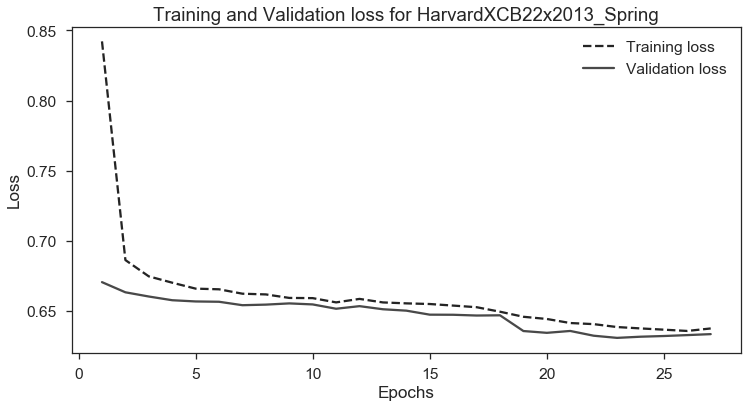

In [29]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

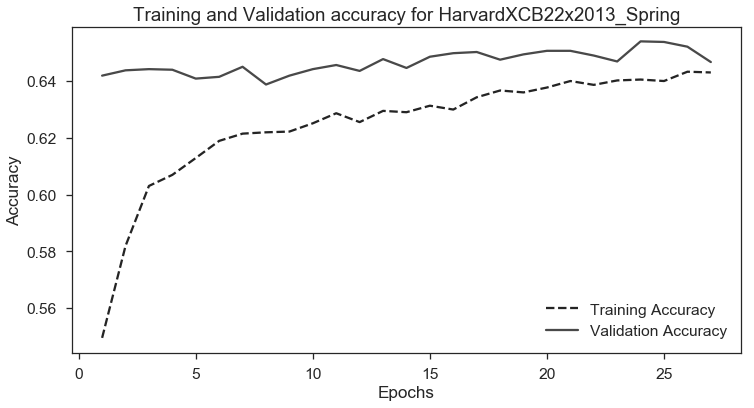

In [30]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [31]:
best_model = load_model('best-keras-runs/HarvardXCB22x2013_Spring-24-0.65.hdf5')

In [32]:
best_model.evaluate(features_train, labels_train, batch_size=128)

19200/19200 [==============================] - 0s 11us/step


[0.6330999302864074, 0.64671875]

In [33]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_train, labels_train, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

19200/19200 [==============================] - 0s 7us/step


### 2. CS50x - Introduction to Computer Science I

In [34]:
course_idx = 1
print(COURSE_LIST[course_idx])

HarvardXCS50x2012


In [35]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

processed-final/HarvardXCS50x2012


In [36]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [37]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [38]:
features_train.shape

(135696, 19)

In [39]:
labels_train.shape

(135696,)

In [40]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [41]:
features_train.shape, features_validation.shape

((108556, 19), (27140, 19))

In [42]:
labels_train.shape, labels_validation.shape

((108556,), (27140,))

In [43]:
K.clear_session()

In [44]:
model = build(nb_initial_layer=32, dense_layer_lst=[32, 32, 32], dpt_rate=0.1, learning_rate=1e-4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                640       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [45]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [46]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

Train on 108556 samples, validate on 27140 samples
Epoch 1/100
108556/108556 [==============================] - 3s 23us/step - loss: 1.1098 - binary_accuracy: 0.5766 - val_loss: 0.6277 - val_binary_accuracy: 0.6620

Epoch 00001: val_binary_accuracy improved from -inf to 0.66201, saving model to best-keras-runs/HarvardXCS50x2012-01-0.66.hdf5
Epoch 2/100
108556/108556 [==============================] - 2s 20us/step - loss: 0.7145 - binary_accuracy: 0.6132 - val_loss: 0.6279 - val_binary_accuracy: 0.6611

Epoch 00002: val_binary_accuracy did not improve from 0.66201
Epoch 3/100
108556/108556 [==============================] - 2s 20us/step - loss: 0.6692 - binary_accuracy: 0.6259 - val_loss: 0.6235 - val_binary_accuracy: 0.6651

Epoch 00003: val_binary_accuracy improved from 0.66201 to 0.66514, saving model to best-keras-runs/HarvardXCS50x2012-03-0.67.hdf5
Epoch 4/100
108556/108556 [==============================] - 2s 19us/step - loss: 0.6530 - binary_accuracy: 0.6372 - val_loss: 0.6248 -

108556/108556 [==============================] - 2s 19us/step - loss: 0.6110 - binary_accuracy: 0.6704 - val_loss: 0.6016 - val_binary_accuracy: 0.6804

Epoch 00033: val_binary_accuracy improved from 0.67859 to 0.68036, saving model to best-keras-runs/HarvardXCS50x2012-33-0.68.hdf5
Epoch 34/100
108556/108556 [==============================] - 2s 20us/step - loss: 0.6106 - binary_accuracy: 0.6713 - val_loss: 0.6029 - val_binary_accuracy: 0.6749

Epoch 00034: val_binary_accuracy did not improve from 0.68036
Epoch 35/100
108556/108556 [==============================] - 2s 19us/step - loss: 0.6111 - binary_accuracy: 0.6712 - val_loss: 0.6024 - val_binary_accuracy: 0.6760

Epoch 00035: val_binary_accuracy did not improve from 0.68036
Epoch 36/100
108556/108556 [==============================] - 2s 20us/step - loss: 0.6105 - binary_accuracy: 0.6704 - val_loss: 0.6028 - val_binary_accuracy: 0.6740

Epoch 00036: val_binary_accuracy did not improve from 0.68036
Epoch 37/100
108556/108556 [=====

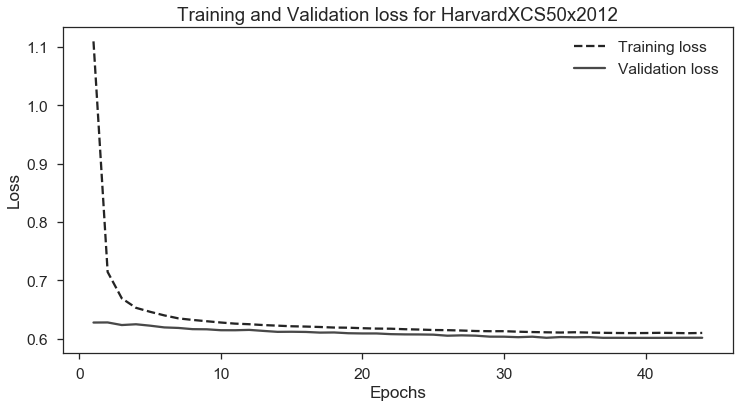

In [47]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

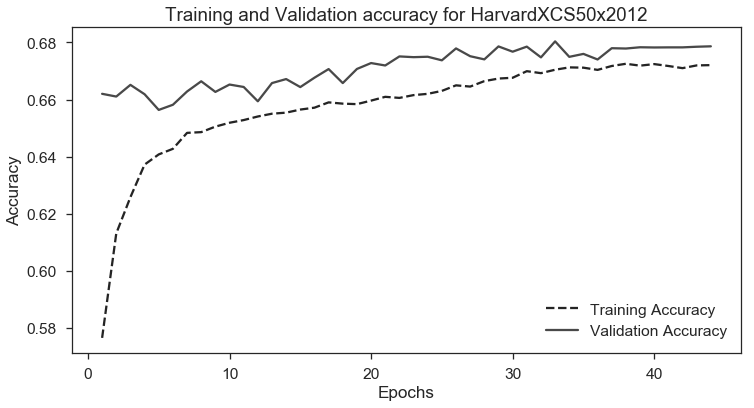

In [48]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [49]:
best_model = load_model('best-keras-runs/HarvardXCS50x2012-33-0.68.hdf5')

In [50]:
best_model.evaluate(features_train, labels_train, batch_size=128)

108556/108556 [==============================] - 1s 8us/step


[0.6077792773399977, 0.6746287630369433]

In [51]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_train, labels_train, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

108556/108556 [==============================] - 1s 8us/step


### 3. ER22x - Justice

In [52]:
course_idx = 2
print(COURSE_LIST[course_idx])

HarvardXER22x2013_Spring


In [53]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

processed-final/HarvardXER22x2013_Spring


In [54]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [55]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [56]:
features_train.shape

(45924, 18)

In [57]:
labels_train.shape

(45924,)

In [58]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [59]:
features_train.shape, features_validation.shape

((36739, 18), (9185, 18))

In [60]:
labels_train.shape, labels_validation.shape

((36739,), (9185,))

In [71]:
K.clear_session()

In [72]:
model = build(nb_initial_layer=32, dense_layer_lst=[32, 32, 32], dpt_rate=0.1, learning_rate=1e-5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                608       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [69]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [73]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

Train on 36739 samples, validate on 9185 samples
Epoch 1/100
36739/36739 [==============================] - 1s 34us/step - loss: 1.1773 - binary_accuracy: 0.5650 - val_loss: 0.8044 - val_binary_accuracy: 0.6574

Epoch 00001: val_binary_accuracy improved from -inf to 0.65738, saving model to best-keras-runs/HarvardXER22x2013_Spring-01-0.66.hdf5
Epoch 2/100
36739/36739 [==============================] - 1s 20us/step - loss: 1.1268 - binary_accuracy: 0.5622 - val_loss: 0.7880 - val_binary_accuracy: 0.6608

Epoch 00002: val_binary_accuracy improved from 0.65738 to 0.66075, saving model to best-keras-runs/HarvardXER22x2013_Spring-02-0.66.hdf5
Epoch 3/100
36739/36739 [==============================] - 1s 21us/step - loss: 1.0632 - binary_accuracy: 0.5705 - val_loss: 0.7561 - val_binary_accuracy: 0.6652

Epoch 00003: val_binary_accuracy improved from 0.66075 to 0.66522, saving model to best-keras-runs/HarvardXER22x2013_Spring-03-0.67.hdf5
Epoch 4/100
36739/36739 [=============================

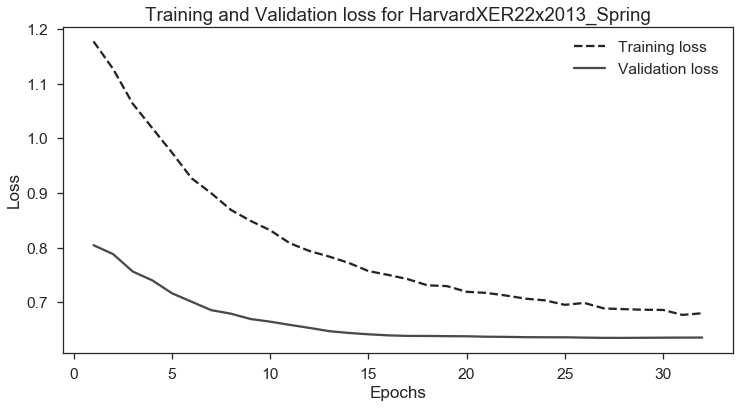

In [74]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

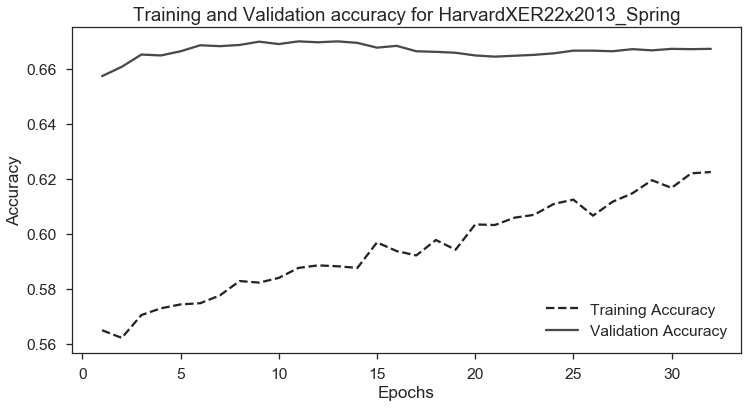

In [75]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [76]:
best_model = load_model('best-keras-runs/HarvardXER22x2013_Spring-18-0.67.hdf5')

In [77]:
best_model.evaluate(features_train, labels_train, batch_size=128)

36739/36739 [==============================] - 0s 9us/step


[0.6531839793292817, 0.6629739513868097]

In [78]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_train, labels_train, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

36739/36739 [==============================] - 0s 7us/step


### 4. PH207x - Health in Numbers: Quantitative Methods in Clinical & Public Health Research

In [79]:
course_idx = 3
print(COURSE_LIST[course_idx])

HarvardXPH207x2012_Fall


In [80]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

processed-final/HarvardXPH207x2012_Fall


In [81]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [82]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [83]:
features_train.shape

(33273, 18)

In [84]:
labels_train.shape

(33273,)

In [85]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [86]:
features_train.shape, features_validation.shape

((26618, 18), (6655, 18))

In [87]:
labels_train.shape, labels_validation.shape

((26618,), (6655,))

In [132]:
K.clear_session()

In [133]:
model = build(nb_initial_layer=32, dense_layer_lst=[32, 32, 32], dpt_rate=0.01, learning_rate=1e-4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                608       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [135]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-8-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [130]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [136]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

Train on 26618 samples, validate on 6655 samples
Epoch 1/100
26618/26618 [==============================] - 1s 35us/step - loss: 0.7042 - binary_accuracy: 0.5819 - val_loss: 0.6427 - val_binary_accuracy: 0.6252

Epoch 00001: val_binary_accuracy improved from -inf to 0.62524, saving model to best-keras-runs/HarvardXPH207x2012_Fall-8-01-0.63.hdf5
Epoch 2/100
26618/26618 [==============================] - 1s 20us/step - loss: 0.6646 - binary_accuracy: 0.6213 - val_loss: 0.6428 - val_binary_accuracy: 0.6249

Epoch 00002: val_binary_accuracy did not improve from 0.62524
Epoch 3/100
26618/26618 [==============================] - 1s 24us/step - loss: 0.6599 - binary_accuracy: 0.6247 - val_loss: 0.6420 - val_binary_accuracy: 0.6278

Epoch 00003: val_binary_accuracy improved from 0.62524 to 0.62780, saving model to best-keras-runs/HarvardXPH207x2012_Fall-8-03-0.63.hdf5
Epoch 4/100
26618/26618 [==============================] - 1s 21us/step - loss: 0.6567 - binary_accuracy: 0.6278 - val_loss: 0.

26618/26618 [==============================] - 1s 20us/step - loss: 0.6364 - binary_accuracy: 0.6408 - val_loss: 0.6339 - val_binary_accuracy: 0.6373

Epoch 00033: val_binary_accuracy did not improve from 0.63967
Epoch 34/100
26618/26618 [==============================] - 1s 22us/step - loss: 0.6351 - binary_accuracy: 0.6442 - val_loss: 0.6339 - val_binary_accuracy: 0.6352

Epoch 00034: val_binary_accuracy did not improve from 0.63967
Epoch 35/100
26618/26618 [==============================] - 1s 20us/step - loss: 0.6348 - binary_accuracy: 0.6433 - val_loss: 0.6341 - val_binary_accuracy: 0.6353

Epoch 00035: val_binary_accuracy did not improve from 0.63967
Epoch 36/100
26618/26618 [==============================] - 1s 19us/step - loss: 0.6347 - binary_accuracy: 0.6434 - val_loss: 0.6332 - val_binary_accuracy: 0.6379

Epoch 00036: val_binary_accuracy did not improve from 0.63967
Epoch 37/100
26618/26618 [==============================] - 1s 20us/step - loss: 0.6338 - binary_accuracy: 0.

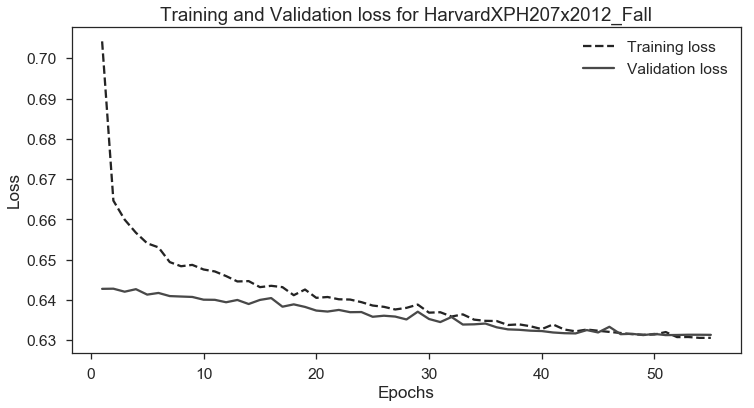

In [137]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

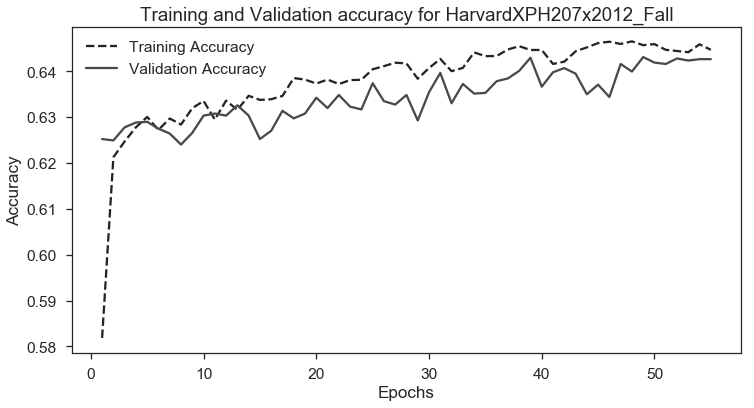

In [138]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [139]:
best_model = load_model('best-keras-runs/HarvardXPH207x2012_Fall-14-0.65.hdf5')

In [140]:
best_model.evaluate(features_train, labels_train, batch_size=128)

26618/26618 [==============================] - 0s 10us/step


[0.6312641254077945, 0.6518521301464579]

In [141]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_train, labels_train, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

26618/26618 [==============================] - 0s 9us/step


### 5. PH278x - Human Health and Global Environmental Change

In [142]:
course_idx = 4
print(COURSE_LIST[course_idx])

HarvardXPH278x2013_Spring


In [143]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

processed-final/HarvardXPH278x2013_Spring


In [144]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [145]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [146]:
features_train.shape

(31681, 18)

In [147]:
labels_train.shape

(31681,)

In [148]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [149]:
features_train.shape, features_validation.shape

((25344, 18), (6337, 18))

In [150]:
labels_train.shape, labels_validation.shape

((25344,), (6337,))

In [180]:
K.clear_session()

In [181]:
model = build(nb_initial_layer=32, dense_layer_lst=[32, 32, 32], dpt_rate=0.2, learning_rate=1e-4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                608       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [182]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-6-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [130]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [183]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

Train on 25344 samples, validate on 6337 samples
Epoch 1/100
25344/25344 [==============================] - 1s 45us/step - loss: 2.1962 - binary_accuracy: 0.5619 - val_loss: 0.8517 - val_binary_accuracy: 0.7077

Epoch 00001: val_binary_accuracy improved from -inf to 0.70775, saving model to best-keras-runs/HarvardXPH278x2013_Spring-6-01-0.71.hdf5
Epoch 2/100
25344/25344 [==============================] - 1s 20us/step - loss: 1.3924 - binary_accuracy: 0.5730 - val_loss: 0.6175 - val_binary_accuracy: 0.7125

Epoch 00002: val_binary_accuracy improved from 0.70775 to 0.71248, saving model to best-keras-runs/HarvardXPH278x2013_Spring-6-02-0.71.hdf5
Epoch 3/100
25344/25344 [==============================] - 1s 22us/step - loss: 0.9929 - binary_accuracy: 0.5827 - val_loss: 0.6375 - val_binary_accuracy: 0.6929

Epoch 00003: val_binary_accuracy did not improve from 0.71248
Epoch 4/100
25344/25344 [==============================] - 1s 20us/step - loss: 0.8379 - binary_accuracy: 0.5980 - val_loss

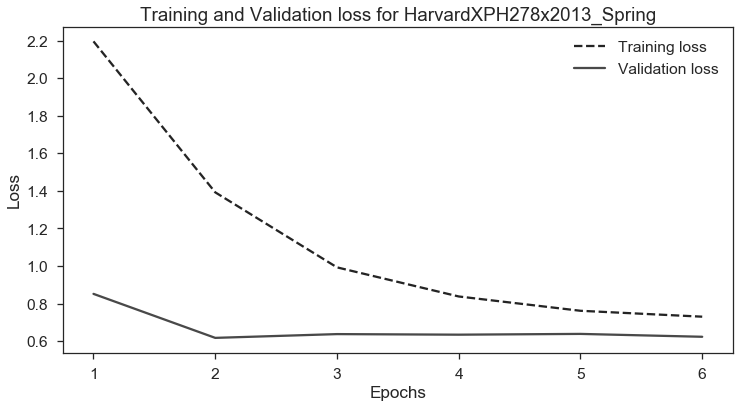

In [184]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

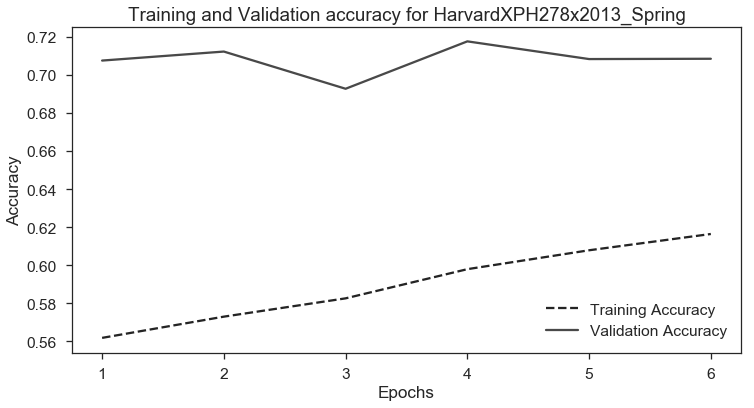

In [185]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [186]:
best_model = load_model('best-keras-runs/HarvardXPH278x2013_Spring-4-07-0.72.hdf5')

In [187]:
best_model.evaluate(features_train, labels_train, batch_size=128)

25344/25344 [==============================] - 0s 10us/step


[0.594254210741833, 0.7116477272727273]

In [197]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_train, labels_train, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

25344/25344 [==============================] - 0s 9us/step


### 6. MIT 14.73x - The Challenges of Global Poverty 

In [198]:
course_idx = 5
print(COURSE_LIST[course_idx])

MITx14.73x2013_Spring


In [199]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

processed-final/MITx14.73x2013_Spring


In [200]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [201]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [202]:
features_train.shape

(22296, 18)

In [203]:
labels_train.shape

(22296,)

In [204]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [205]:
features_train.shape, features_validation.shape

((17836, 18), (4460, 18))

In [206]:
labels_train.shape, labels_validation.shape

((17836,), (4460,))

In [246]:
K.clear_session()

In [247]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1216      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [248]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-8-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [130]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [249]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

Train on 17836 samples, validate on 4460 samples
Epoch 1/100
17836/17836 [==============================] - 1s 45us/step - loss: 0.8805 - binary_accuracy: 0.5627 - val_loss: 0.6804 - val_binary_accuracy: 0.6013

Epoch 00001: val_binary_accuracy improved from -inf to 0.60135, saving model to best-keras-runs/MITx14.73x2013_Spring-8-01-0.60.hdf5
Epoch 2/100
17836/17836 [==============================] - 0s 21us/step - loss: 0.7486 - binary_accuracy: 0.5757 - val_loss: 0.6640 - val_binary_accuracy: 0.6090

Epoch 00002: val_binary_accuracy improved from 0.60135 to 0.60897, saving model to best-keras-runs/MITx14.73x2013_Spring-8-02-0.61.hdf5
Epoch 3/100
17836/17836 [==============================] - 0s 22us/step - loss: 0.7172 - binary_accuracy: 0.5828 - val_loss: 0.6619 - val_binary_accuracy: 0.6114

Epoch 00003: val_binary_accuracy improved from 0.60897 to 0.61143, saving model to best-keras-runs/MITx14.73x2013_Spring-8-03-0.61.hdf5
Epoch 4/100
17836/17836 [==============================] 

17836/17836 [==============================] - 0s 21us/step - loss: 0.6552 - binary_accuracy: 0.6039 - val_loss: 0.6483 - val_binary_accuracy: 0.6202

Epoch 00032: val_binary_accuracy did not improve from 0.62623
Epoch 33/100
17836/17836 [==============================] - 0s 21us/step - loss: 0.6540 - binary_accuracy: 0.6056 - val_loss: 0.6480 - val_binary_accuracy: 0.6217

Epoch 00033: val_binary_accuracy did not improve from 0.62623
Epoch 34/100
17836/17836 [==============================] - 0s 22us/step - loss: 0.6523 - binary_accuracy: 0.6110 - val_loss: 0.6478 - val_binary_accuracy: 0.6235

Epoch 00034: val_binary_accuracy did not improve from 0.62623
Epoch 35/100
17836/17836 [==============================] - 0s 21us/step - loss: 0.6538 - binary_accuracy: 0.6037 - val_loss: 0.6476 - val_binary_accuracy: 0.6235

Epoch 00035: val_binary_accuracy did not improve from 0.62623
Epoch 36/100
17836/17836 [==============================] - 0s 21us/step - loss: 0.6551 - binary_accuracy: 0.

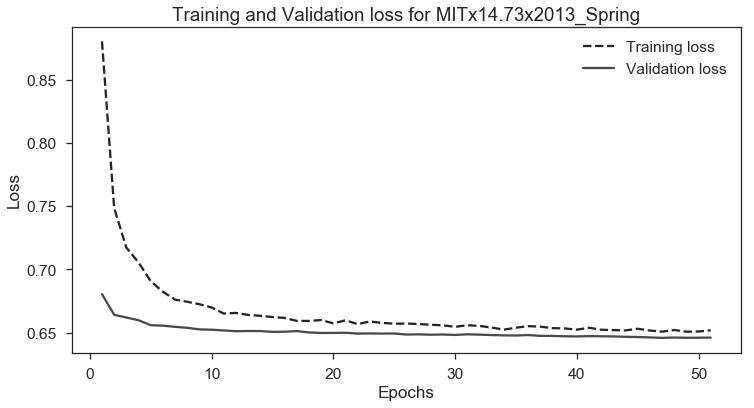

In [250]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

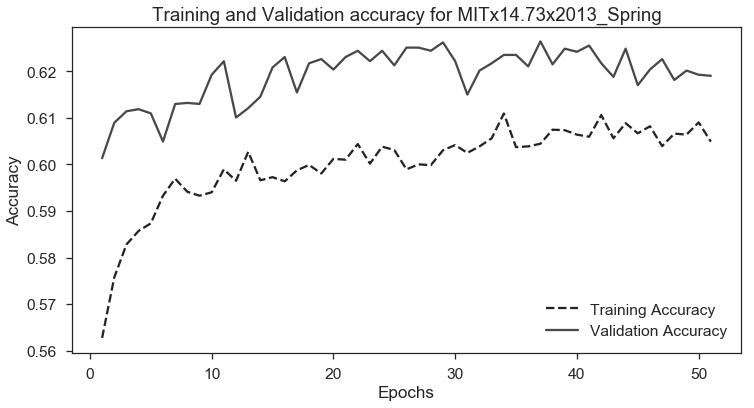

In [251]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [252]:
best_model = load_model('best-keras-runs/MITx14.73x2013_Spring-8-37-0.63.hdf5')

In [258]:
best_model.evaluate(features_validation, labels_validation, batch_size=64)

4460/4460 [==============================] - 0s 16us/step


[0.6473972263892135, 0.6264573989427678]

In [259]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_validation, labels_validation, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

4460/4460 [==============================] - 0s 11us/step


### 7. MIT 2.01x - Elements of Structures

In [301]:
course_idx = 6
print(COURSE_LIST[course_idx])

MITx2.01x2013_Spring


In [302]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

processed-final/MITx2.01x2013_Spring


In [303]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [304]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [305]:
features_train.shape

(4532, 18)

In [306]:
labels_train.shape

(4532,)

In [307]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [308]:
features_train.shape, features_validation.shape

((3625, 18), (907, 18))

In [309]:
labels_train.shape, labels_validation.shape

((3625,), (907,))

In [337]:
K.clear_session()

In [338]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1216      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [339]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-11-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [130]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [340]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

Train on 3625 samples, validate on 907 samples
Epoch 1/100
3625/3625 [==============================] - 1s 161us/step - loss: 0.9147 - binary_accuracy: 0.6701 - val_loss: 0.8802 - val_binary_accuracy: 0.6604

Epoch 00001: val_binary_accuracy improved from -inf to 0.66042, saving model to best-keras-runs/MITx2.01x2013_Spring-11-01-0.66.hdf5
Epoch 2/100
3625/3625 [==============================] - 0s 27us/step - loss: 0.8822 - binary_accuracy: 0.6654 - val_loss: 0.8304 - val_binary_accuracy: 0.6615

Epoch 00002: val_binary_accuracy improved from 0.66042 to 0.66152, saving model to best-keras-runs/MITx2.01x2013_Spring-11-02-0.66.hdf5
Epoch 3/100
3625/3625 [==============================] - 0s 25us/step - loss: 0.8607 - binary_accuracy: 0.6632 - val_loss: 0.7916 - val_binary_accuracy: 0.6615

Epoch 00003: val_binary_accuracy did not improve from 0.66152
Epoch 4/100
3625/3625 [==============================] - 0s 25us/step - loss: 0.8415 - binary_accuracy: 0.6566 - val_loss: 0.7570 - val_bi

3625/3625 [==============================] - 0s 23us/step - loss: 0.6924 - binary_accuracy: 0.6450 - val_loss: 0.6298 - val_binary_accuracy: 0.6615

Epoch 00036: val_binary_accuracy did not improve from 0.66373
Epoch 37/100
3625/3625 [==============================] - 0s 23us/step - loss: 0.7022 - binary_accuracy: 0.6375 - val_loss: 0.6295 - val_binary_accuracy: 0.6593

Epoch 00037: val_binary_accuracy did not improve from 0.66373
Epoch 38/100
3625/3625 [==============================] - 0s 23us/step - loss: 0.6826 - binary_accuracy: 0.6439 - val_loss: 0.6295 - val_binary_accuracy: 0.6604

Epoch 00038: val_binary_accuracy did not improve from 0.66373
Epoch 39/100
3625/3625 [==============================] - 0s 22us/step - loss: 0.6796 - binary_accuracy: 0.6513 - val_loss: 0.6295 - val_binary_accuracy: 0.6604

Epoch 00039: val_binary_accuracy did not improve from 0.66373
Epoch 40/100
3625/3625 [==============================] - 0s 24us/step - loss: 0.6910 - binary_accuracy: 0.6430 - val

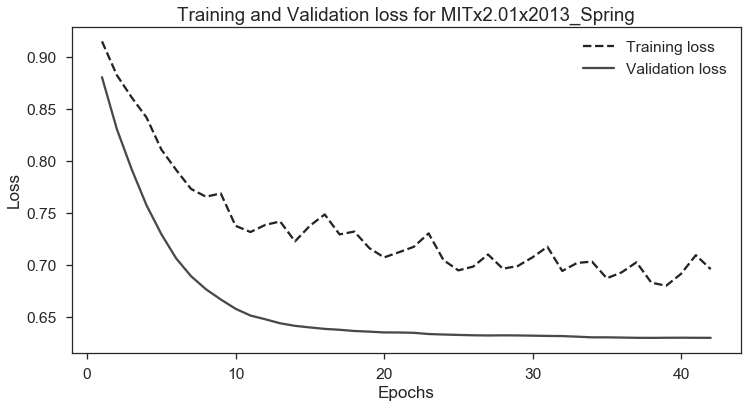

In [341]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

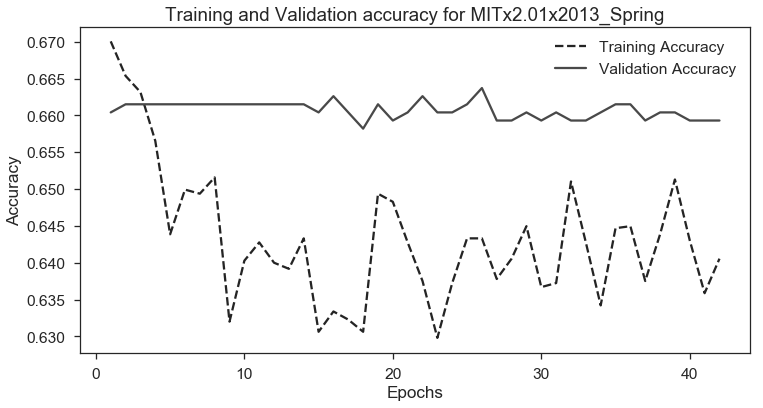

In [342]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [343]:
best_model = load_model('best-keras-runs/MITx2.01x2013_Spring-11-26-0.66.hdf5')

In [344]:
best_model.evaluate(features_train, labels_train, batch_size=128)

3625/3625 [==============================] - 0s 33us/step


[0.6064206970806779, 0.6755862066827971]

In [345]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_validation, labels_validation, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

907/907 [==============================] - 0s 18us/step


### 8. MIT 3.091x (Fall) - Introduction to Solid State Chemistry

In [346]:
course_idx = 7
print(COURSE_LIST[course_idx])

MITx3.091x2012_Fall


In [347]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

processed-final/MITx3.091x2012_Fall


In [348]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [349]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [350]:
features_train.shape

(11372, 18)

In [351]:
labels_train.shape

(11372,)

In [352]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [353]:
features_train.shape, features_validation.shape

((9097, 18), (2275, 18))

In [354]:
labels_train.shape, labels_validation.shape

((9097,), (2275,))

In [382]:
K.clear_session()

In [383]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.01, learning_rate=1e-5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1216      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [384]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-6-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [130]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [385]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

Train on 9097 samples, validate on 2275 samples
Epoch 1/100
9097/9097 [==============================] - 1s 84us/step - loss: 1.2941 - binary_accuracy: 0.3923 - val_loss: 1.2386 - val_binary_accuracy: 0.3749

Epoch 00001: val_binary_accuracy improved from -inf to 0.37495, saving model to best-keras-runs/MITx3.091x2012_Fall-6-01-0.37.hdf5
Epoch 2/100
9097/9097 [==============================] - 0s 22us/step - loss: 1.1672 - binary_accuracy: 0.3920 - val_loss: 1.1013 - val_binary_accuracy: 0.3780

Epoch 00002: val_binary_accuracy improved from 0.37495 to 0.37802, saving model to best-keras-runs/MITx3.091x2012_Fall-6-02-0.38.hdf5
Epoch 3/100
9097/9097 [==============================] - 0s 22us/step - loss: 1.0409 - binary_accuracy: 0.3942 - val_loss: 0.9707 - val_binary_accuracy: 0.3789

Epoch 00003: val_binary_accuracy improved from 0.37802 to 0.37890, saving model to best-keras-runs/MITx3.091x2012_Fall-6-03-0.38.hdf5
Epoch 4/100
9097/9097 [==============================] - 0s 22us/step 

9097/9097 [==============================] - 0s 30us/step - loss: 0.6771 - binary_accuracy: 0.6015 - val_loss: 0.6557 - val_binary_accuracy: 0.6207

Epoch 00032: val_binary_accuracy did not improve from 0.62681
Epoch 33/100
9097/9097 [==============================] - 0s 22us/step - loss: 0.6795 - binary_accuracy: 0.5953 - val_loss: 0.6555 - val_binary_accuracy: 0.6202

Epoch 00033: val_binary_accuracy did not improve from 0.62681
Epoch 34/100
9097/9097 [==============================] - 0s 22us/step - loss: 0.6798 - binary_accuracy: 0.5950 - val_loss: 0.6554 - val_binary_accuracy: 0.6202

Epoch 00034: val_binary_accuracy did not improve from 0.62681
Epoch 35/100
9097/9097 [==============================] - 0s 22us/step - loss: 0.6761 - binary_accuracy: 0.5977 - val_loss: 0.6553 - val_binary_accuracy: 0.6202

Epoch 00035: val_binary_accuracy did not improve from 0.62681
Epoch 36/100
9097/9097 [==============================] - 0s 21us/step - loss: 0.6758 - binary_accuracy: 0.6007 - val


Epoch 00068: val_binary_accuracy did not improve from 0.62681
Epoch 69/100
9097/9097 [==============================] - 0s 23us/step - loss: 0.6679 - binary_accuracy: 0.6094 - val_loss: 0.6539 - val_binary_accuracy: 0.6220

Epoch 00069: val_binary_accuracy did not improve from 0.62681
Epoch 70/100
9097/9097 [==============================] - 0s 23us/step - loss: 0.6663 - binary_accuracy: 0.6068 - val_loss: 0.6539 - val_binary_accuracy: 0.6220

Epoch 00070: val_binary_accuracy did not improve from 0.62681
Epoch 71/100
9097/9097 [==============================] - 0s 22us/step - loss: 0.6667 - binary_accuracy: 0.6078 - val_loss: 0.6539 - val_binary_accuracy: 0.6229

Epoch 00071: val_binary_accuracy did not improve from 0.62681
Epoch 72/100
9097/9097 [==============================] - 0s 22us/step - loss: 0.6673 - binary_accuracy: 0.6056 - val_loss: 0.6538 - val_binary_accuracy: 0.6220

Epoch 00072: val_binary_accuracy did not improve from 0.62681
Epoch 73/100
9097/9097 [=================

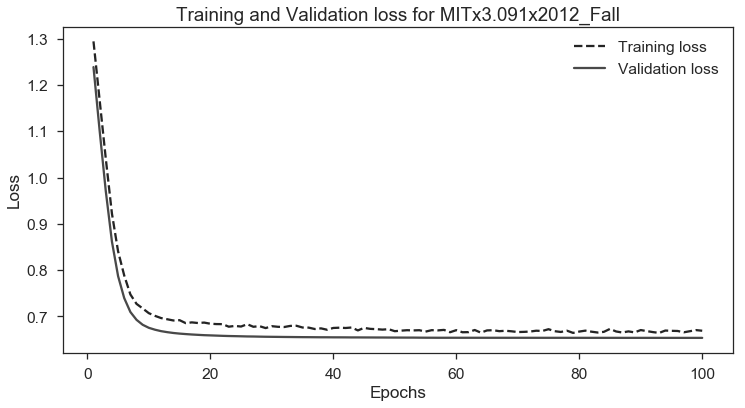

In [386]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

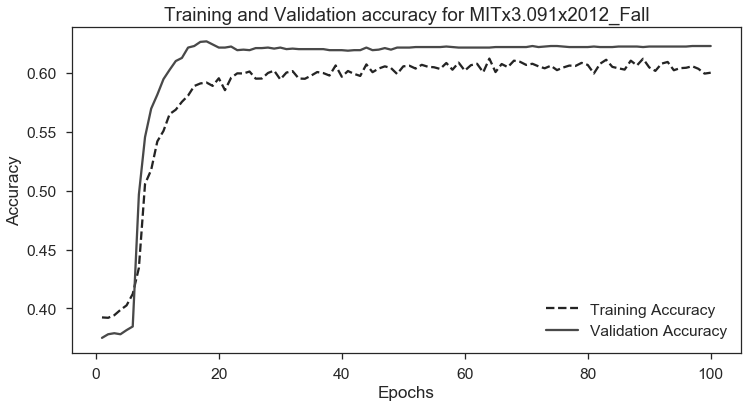

In [387]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [343]:
best_model = load_model('best-keras-runs/MITx2.01x2013_Spring-11-26-0.66.hdf5')

In [344]:
best_model.evaluate(features_train, labels_train, batch_size=128)

3625/3625 [==============================] - 0s 33us/step


[0.6064206970806779, 0.6755862066827971]

In [345]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_validation, labels_validation, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

907/907 [==============================] - 0s 18us/step


### 9. MIT 3.091x (Spring) - Introduction to Solid State Chemistry 

In [ ]:
course_idx = 8
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 10. MIT 6.002x (Fall) - Circuits and Electronics

In [ ]:
course_idx = 9
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 11. MIT 6.002x (Spring) - Circuits and Electronics

In [ ]:
course_idx = 10
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 12. MIT 6.00x (Fall) - Introduction to Computer Science

In [ ]:
course_idx = 11
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 13. MIT 6.00x (Spring) - Introduction to Computer Science

In [ ]:
course_idx = 12
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 14. MIT 7.00x - Introduction to Biology - secret of life

In [ ]:
course_idx = 13
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 15. MIT 8.02x - Electricity and Magnetism

In [ ]:
course_idx = 14
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 16. MIT 8.MReV - Mechanics Review

In [ ]:
course_idx = 15
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))